<a href="https://colab.research.google.com/github/ShivajiMallela/Deep-learning-with-Tensorflow/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10. Milestone Project 3: Time Series Forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to help you get familiar with working with time series data.

In this project, we’ll build a series of models to attempt to predict the price of Bitcoin.

Welcome to Milestone Project 3, BitPredict 💰📈!

> 🔑 **Note:** ⚠️ This is not financial advice. As you'll see, time series forecasting for stock market prices can be quite challenging.

## What is a Time Series Problem?

Time series problems involve data collected over time.

Examples include:
- The number of staff members in a company over 10 years
- Sales of computers over the past 5 years
- Electricity usage over the past 50 years

Time series can range from short (seconds/minutes) to long (years/decades). The problems you investigate can generally be categorized into two types:


| Problem Type | Examples | Output |
| ------------ | -------- | ------ |
| **Classification** | Anomaly detection, time series identification (e.g., identifying the source of a time series) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future product demand, determining inventory requirements | Continuous (a number) |

In both cases, a supervised learning approach is typically used, meaning you have example data with associated labels.

For instance, in forecasting Bitcoin prices, your data could be the historical prices of Bitcoin over the past month, and the label could be today’s price (the label isn’t tomorrow’s price because that’s what we’re trying to predict).

So, can you guess what kind of problem BitPredict 💰📈 is?

## What We’re Going to Cover

Are you ready? We have a lot to go through:

* **Get Time Series Data**:
  - Load historical Bitcoin prices using pandas/Python's CSV module
* **Format Data for a Time Series Problem**:
  - Creating training and test sets (the wrong way)
  - Creating training and test sets (the right way)
  - Visualizing time series data
  - Turning time series data into a supervised learning problem (windowing)
  - Preparing univariate and multivariate (more than one variable) data
* **Evaluating a Time Series Forecasting Model**
* **Setting Up a Series of Deep Learning Modelling Experiments**:
  - Dense (fully-connected) networks
  - Sequence models (LSTM and 1D CNN)
  - Ensembling (combining multiple models together)
  - Multivariate models
  - Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* **Creating a Model Checkpoint** to save the best performing model during training
* **Making Predictions (Forecasts)** with a Time Series Model
* **Creating Prediction Intervals** for Time Series Model Forecasts
* **Discussing Two Different Types of Uncertainty in Machine Learning**: Data Uncertainty and Model Uncertainty
* **Demonstrating the Challenges of Forecasting in an Open System** (the Turkey Problem)


## Get Data

To build a time series forecasting model, the first thing we need is data.

Since we’re aiming to predict the price of Bitcoin, we’ll require historical Bitcoin data.

Specifically, we’ll be using Bitcoin prices from **01 October 2013** to **18 May 2021**.

### Why these dates?

- **01 October 2013**: This is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording Bitcoin prices.
- **18 May 2021**: This is the date when this notebook was created by instructor.

If you’re following this notebook at a later date, you can apply the same methods to predict on newer data—you’ll just need to adjust the data source accordingly.

> 📖 **Resource:** To get the historical Bitcoin data, visit the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), click on "All," then click on "Export Data" and select "CSV."

You can also access the data we’re using from [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).


In [1]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-08-25 16:05:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2024-08-25 16:05:22 (38.4 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas
Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in **CSV (comma separated values)** format (a very common data format for time series), we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").

In [2]:
#import with pandas
import pandas as pd
# parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates = ['Date'],
                 index_col = ['Date']) # parse the date column

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
len(df)

2787

In [5]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


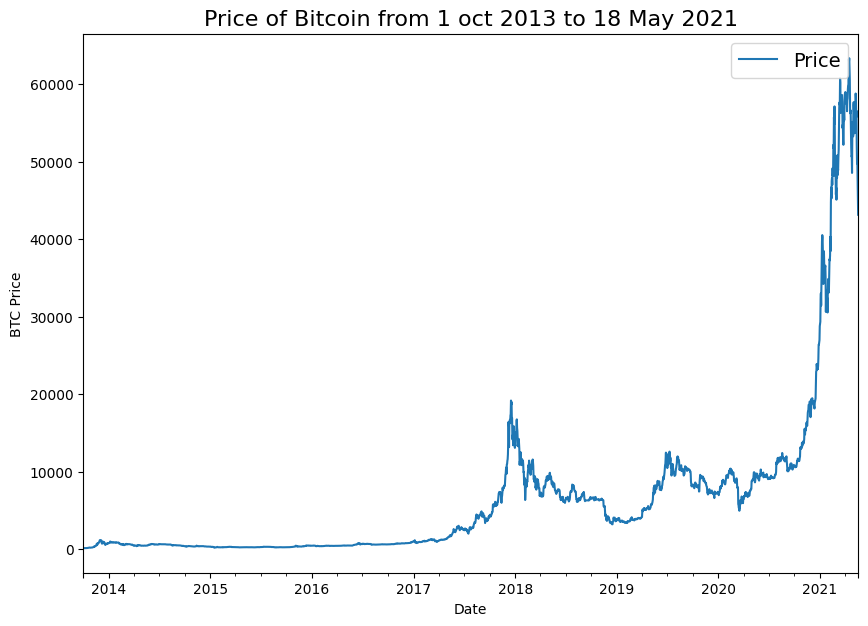

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Format Data Part 1: Creating Train and Test Sets for Time Series Data

What’s the next step?

If you guessed preparing our data for the model, you’re spot on.

### What’s the most important first step in preparing any machine learning dataset?

- Scaling?
  - No...
- Removing outliers?
  - No...
- How about creating train and test splits?
  - Yes!

Typically, you might use a function like Scikit-Learn’s [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to create train and test splits. However, as we’ll soon discover, this approach isn’t ideal for time series data.

### What kind of data do we have?

Before creating splits, it’s essential to understand the type of data we're working with.

In time series problems, your data can be either **univariate** or **multivariate**.

- **Univariate** time series data involves a single variable, such as using the price of Bitcoin to predict future prices of Bitcoin.
- **Multivariate** time series data involves multiple variables, such as predicting electricity demand using factors like the day of the week, time of year, and the number of houses in a region.
  
Can you guess which one our data falls under?


### Create train & test sets for time series (the wrong way)

ok, we've figured out we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables).

How about we first see the *wrong way* for splitting time series data?

Let's turn our DataFrame index and column into NumPy arrays.

In [7]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [8]:
# wrong way of splitting train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                  prices,
                                                  test_size=0.2,
                                                  random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

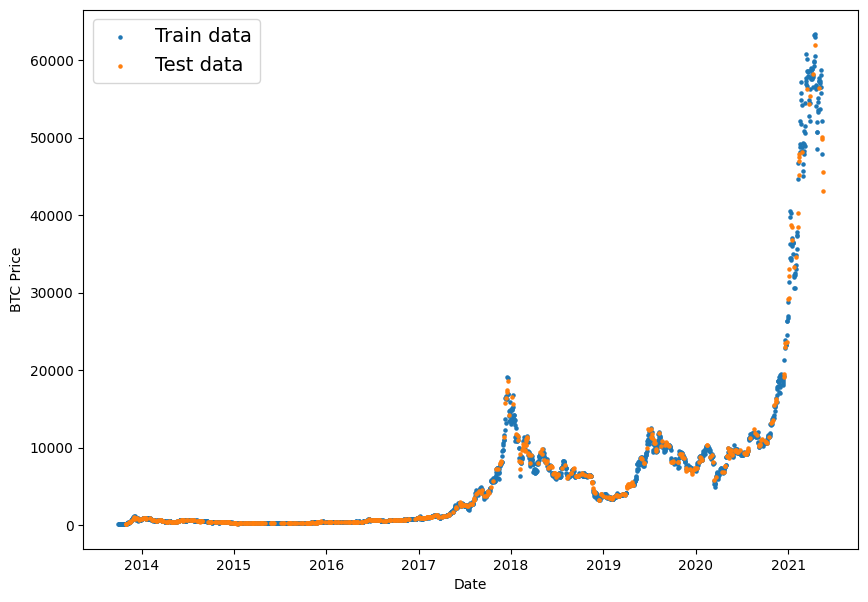

In [9]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

In [10]:
# Create train and test splits the right way for time series data
split_size = int(0.8*len(prices))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [11]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  #plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) #Make label bigger
  plt.grid(True)

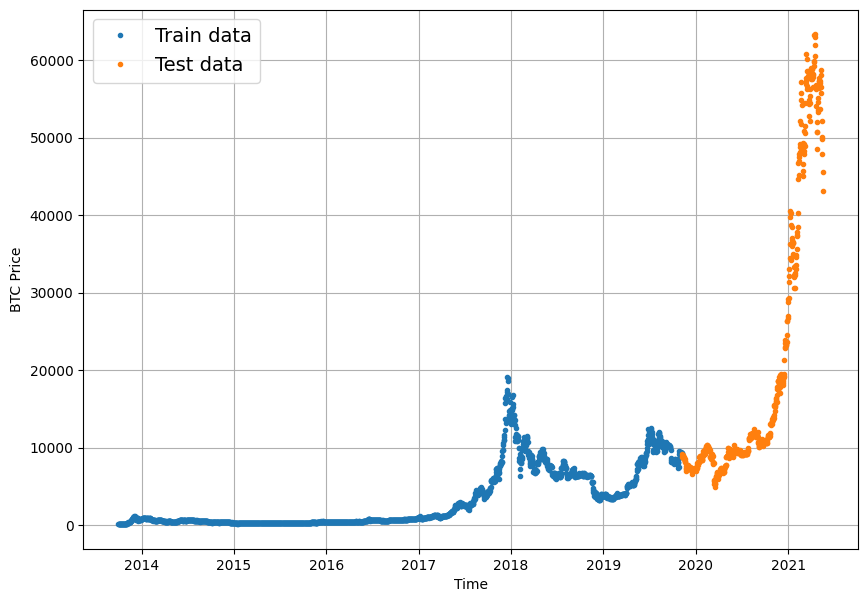

In [12]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, label="Test data")

## Modeling Experiments

We can create a wide variety of models for our problem, as long as the data inputs and outputs are properly formatted.

However, just because we *can* build *almost any* model, it doesn't mean it will perform well or be suitable for production use. We’ll explore this as we build and evaluate different models.

### Two Key Terms: **Horizon** and **Window**

Before diving into our modeling experiments, it's important to understand two key concepts:

- **Horizon**: The number of time steps to predict into the future.
- **Window**: The number of past time steps used to predict the horizon.

For example, if we want to predict tomorrow's Bitcoin price (1-day horizon) using the last week's worth of prices (7-day window), the horizon would be 1, and the window would be 7.

### Modeling Experiments Overview

Now, let’s take a look at the modeling experiments we’ll run:

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ------------- | ------------- | ------------- | ------------- | ------------- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model | 1 | 7 | NA|
| 10 | Same as 1 (with turkey 🦃 data introduced) | 1 | 7 | NA |

> 🔑 **Note:** As you can see, we can build various models for the data we’re working with. However, this doesn’t guarantee their performance. Deep learning is a powerful tool, but it doesn’t always work. Always start with a simple model, then add complexity as needed.


## Model 0: Naïve Forecast (Baseline)

Let's begin with a baseline model.

One of the most common baselines for time series forecasting is the naïve model (also known as the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)). The best part? It requires no training.

The naïve model simply predicts that the next timestep's value will be the same as the previous timestep's value. The formula for this is:

$$\hat{y}_{t} = y_{t-1}$$

In plain English:
> The prediction at timestep `t` (y-hat) is the same as the value at timestep `t-1` (the previous timestep).

Sounds simple, right?

But in an open system, like a stock or crypto market, it’s often surprisingly difficult to beat the naïve forecast with more complex models.

> 🔑 **Note:** In this notebook, an **open system** refers to a system where inputs and outputs can freely flow, such as a market (stock or crypto). On the other hand, a **closed system** is where inputs and outputs are contained within the system (like a poker game with your friends, where you know the buy-in and the potential winnings). Time series forecasting in **open systems** is typically challenging.


In [13]:
# creata a naive forecast
naive_forecast = y_test[:-1] # Naive forecast equals value excluding the last value
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [14]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

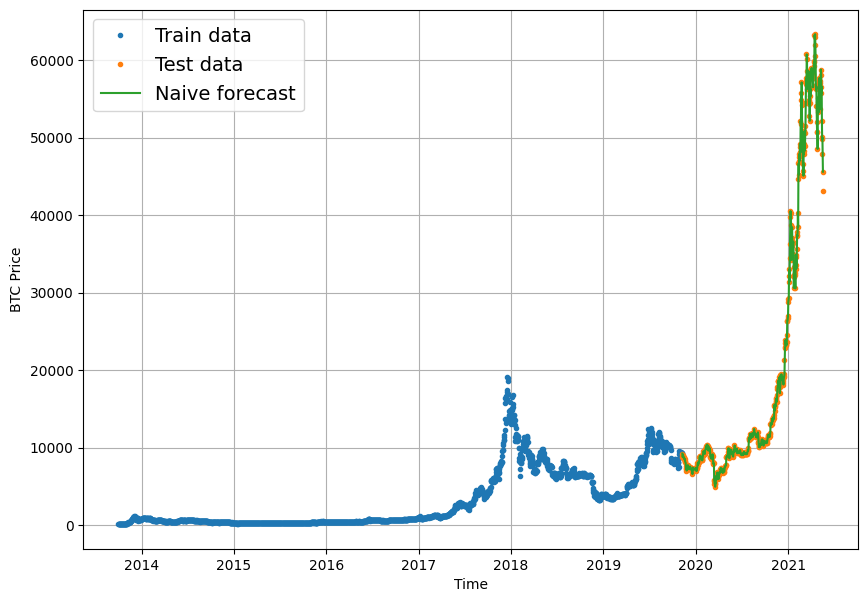

In [15]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label='Test data')
plot_time_series(X_test[1:], naive_forecast, format='-', label='Naive forecast')

The naive forecast looks like it's following the data well.

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

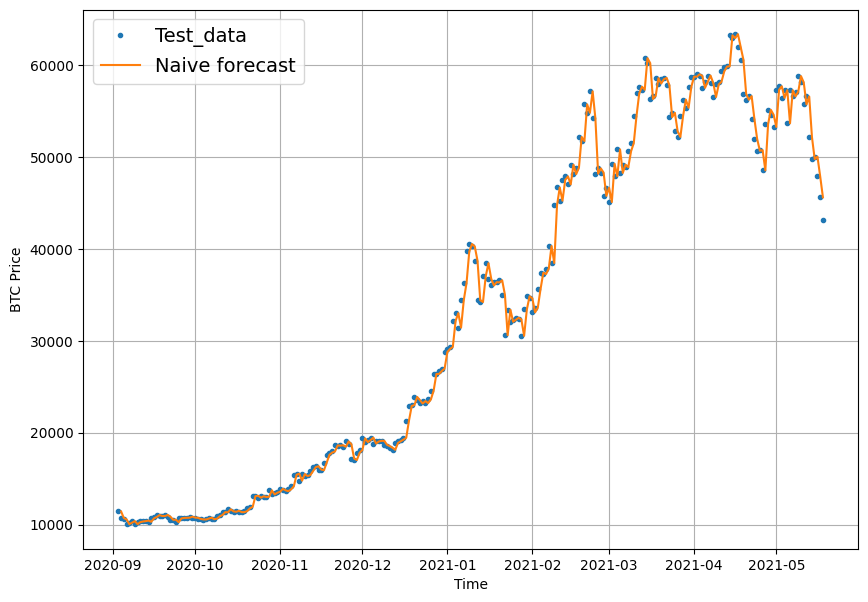

In [16]:
plt.figure(figsize=(10,7))
offset=300
plot_time_series(X_test, y_test, start=offset, label="Test_data")
plot_time_series(X_test[1:], naive_forecast, format='-', start=offset, label='Naive forecast')

## Evaluating a Time Series Model

When forecasting time series data, like predicting Bitcoin's price, we're often dealing with a regression problem.

This means we can use regression evaluation metrics to measure how well our models perform.

The key question we'll focus on is: **How do our model's predictions (`y_pred`) compare to the actual values (`y_true` or *ground truth values*)?**

> 📖 **Resource:** We'll be using several metrics to evaluate the accuracy of our time series forecasts. Many of these metrics are detailed in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html), which provides a deeper understanding of the concepts we'll cover.

For the metrics below, **lower values indicate better performance** (e.g., an MAE of 0 is better than an MAE of 100).

### Scale-Dependent Errors

These metrics compare time series values and forecasts that are on the same scale.

For example, comparing Bitcoin historical prices in USD to forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (Mean Absolute Error) | Easy to interpret (a forecast is X amount different from the actual value). Minimizing MAE leads to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (Root Mean Square Error) | Minimizing RMSE leads to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_squared_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage Errors

Percentage errors have no units, allowing comparisons across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (Mean Absolute Percentage Error) | Most commonly used percentage error. May not work if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) |
| **sMAPE** (Symmetric Mean Absolute Percentage Error) | Not recommended by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though used in forecasting competitions. | Custom implementation |

### Scaled Errors

Scaled errors are an alternative to percentage errors for comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (Mean Absolute Scaled Error) | MASE equals one for the naïve forecast. A forecast performing better than the naïve should have a MASE of less than 1. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

> 🤔 **Question:** With so many metrics, which one should I focus on? It depends on your problem, but MAE is often a good place to start due to its simplicity and ease of explanation.

Since we'll be evaluating many models, let’s write a function to calculate these evaluation metrics for our forecasts.

First, we’ll need TensorFlow.


In [17]:
import tensorflow as tf

In [18]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae/ mae_naive_no_season

In [19]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 for metric calculations
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.MeanAbsoluteError()(y_true, y_pred)
    mse = tf.keras.metrics.MeanSquaredError()(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.MeanAbsolutePercentageError()(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "MAE": mae.numpy(),
        "MSE": mse.numpy(),
        "RMSE": rmse.numpy(),
        "MAPE": mape.numpy(),
        "MASE": mase.numpy()
    }

In [20]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)
naive_results

{'MAE': 567.9802,
 'MSE': 1147547.0,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.69212395}

In [21]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

Since we've got a naïve forecast baseline to work with, it's time we start building models to try and beat it.

And because this course is focused on TensorFlow and deep learning, we're going to be using TensorFlow to build deep learning models to try and improve on our naïve forecasting results.

That being said, there are many other kinds of models you may want to look into for building baselines/performing forecasts.

Some of them may even beat our best performing models in this notebook, however, I'll leave trying them out for extra-curriculum.

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing Dataset

We’re almost ready to start building our models, but there's one more step (really two) to complete.

We need to **window** our time series data.

### Why Window the Data?

Windowing transforms a time series dataset into a **supervised learning problem**.

In other words, we use past data windows to predict future values.

For instance, if we want to use a window of one week (`window=7`) to predict the next single value (`horizon=1`) for a univariate time series, it might look like this:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```


For predicting Bitcoin prices, it would look like this:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).


In [22]:
HORIZON = 1
WINDOW_SIZE = 7

In [23]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset

  E.g. if horizon=1 (Default)
  Input: [1,2,3,4,5,6] -> output: ([1,2,3,4,5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [24]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


### Creating Windows for the Entire Time Series

To efficiently create windows for the entire time series, we could use Python for loops. However, for large datasets, this approach can be slow.

To speed up the process, we’ll use [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

The following steps will help us:

1. We’ll use NumPy to create overlapping slices (windows) of our time series data.
2. These windows will be used to train our models.
3. We’ll apply the `get_labelled_windows()` function (created earlier) to convert these window slices into labeled windows with a specified horizon.

> 📖 **Resource:** The function created below is adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).


In [25]:
import numpy as np
# create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window size
  """
  # 1. create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


To understand above func refer to this:

window_step = `[[0, 1, 2, 3, 4, 5, 6, 7]]`

window_indexes will result in:
`[[0], [1], [2],....] + [[0, 1, 2, 3, 4, 5, 6, 7]]`

This results in:
```
[[0]+[0, 1, 2, 3, 4, 5, 6, 7],
[1]+[0, 1, 2, 3, 4, 5, 6, 7],
[2]+[0, 1, 2, 3, 4, 5, 6, 7],
....] = [[0, 1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8], [2, 3, 4, 5, 6, 7, 8, 9],....]
```

In [26]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [27]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [28]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [29]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [30]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [31]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [32]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Create a Model Checkpoint

We're almost ready to build our models—just one more crucial step!

Given that our model's performance may vary across different experiments, it's important to ensure that we're comparing them fairly. This means we need to compare the best performance of each model against the best performance of other models.

To make this comparison consistent, we'll save each model's best version during training. This approach allows us to run multiple experiments while keeping track of the best-performing models by saving them under different names.

Next, we'll write a small function to create a `ModelCheckpoint` callback, which saves a model to a specified filename.


In [39]:
import os
# create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name+".keras"),
                                            verbose=1,
                                            monitor='val_loss',
                                            save_best_only= True)

## Model 1: Dense model (window = 7, horizon = 1)

Finally!

Time to build one of our models.

If you think we've been through a fair bit of preprocessing before getting here, you're right.

Often, preparing data for a model is one of the largest parts of any machine learning project.

And once you've got a good model in place, you'll probably notice far more improvements from manipulating the data (e.g. collecting more, improving the quality) than manipulating the model.

We're going to start by keeping it simple, model_1 will have:

A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
An output layer with linear activation (or no activation)
Adam optimizer and MAE loss function
Batch size of 128
100 epochs
Why these values?

I picked them out of experimentation.

A batch size of 32 works pretty well too and we could always train for less epochs but since the model runs so fast (you'll see in a second, it's because the number of samples we have isn't massive) we might as well train for more.

> 🔑 **Note:** As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called [**hyperparameters**](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning). And experimenting to find the best values for hyperparameters is called **hyperparameter tuning**. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as **parameters**.

Let's import TensorFlow and build our first deep learning model for time series.

In [40]:
import tensorflow as tf
from tensorflow.keras import layers

#set random seed for as reproducible results as possible
tf.random.set_seed(42)

# construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data = (test_windows, test_labels),
            callbacks= [create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3446.8054 - mae: 3446.8054
Epoch 1: val_loss improved from inf to 5913.01904, saving model to model_experiments/model_1_dense.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 3408.3459 - mae: 3408.3459 - val_loss: 5913.0190 - val_mae: 5913.0190
Epoch 2/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1006.9390 - mae: 1006.9390
Epoch 2: val_loss improved from 5913.01904 to 1030.50989, saving model to model_experiments/model_1_dense.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 545.4313 - mae: 545.4313 - val_loss: 1030.5099 - val_mae: 1030.5099
Epoch 3/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 180.3123 - mae: 180.3123
Epoch 3: val_loss did not improve from 1030.50989
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 218.2297 - mae: 218.2297 - val_loss: 1116.1375 - val_mae: 1116.1375
Epoch 4/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 202.8755 - mae: 202.8755
Epoch 4: val_loss improved from 1030.5098

In [41]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 284.7914 - mae: 284.7914


[571.1243286132812, 571.1243286132812]

In [42]:
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 285.1469 - mae: 285.1469


[571.0994262695312, 571.0994262695312]

## Making Forecasts with a Model (on the Test Dataset)

We've trained our model and evaluated it on the test data. But since our project is called BitPredict 💰📈, how can we use our model to make predictions?

Since we'll be running multiple modeling experiments, let's create a function that:
1. Takes in a trained model (like `model_1`).
2. Accepts some input data (similar to what the model was trained on).
3. Passes the input data through the model's `predict()` method.
4. Returns the predictions.


In [43]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [44]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8858.87 , 8773.532, 9055.829, 8786.824, 8712.585, 8761.53 ,
        8696.831, 8491.698, 8481.834, 8526.588], dtype=float32)>)

In [45]:
#Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_1_preds)

model_1_results

{'MAE': 571.09937,
 'MSE': 1174121.2,
 'RMSE': 1083.5687,
 'MAPE': 2.5541058,
 'MASE': 0.69746816}

In [46]:
naive_results

{'MAE': 567.9802,
 'MSE': 1147547.0,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.69212395}

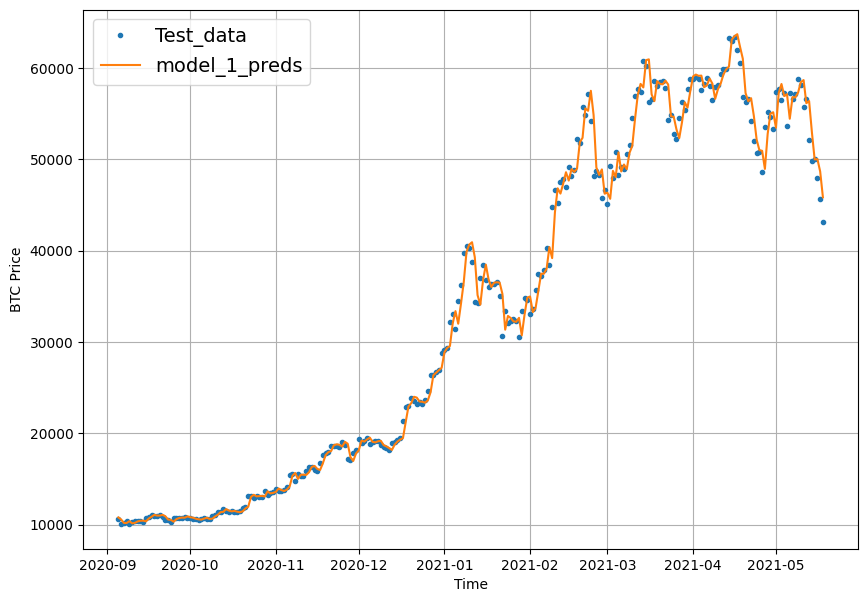

In [51]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label='Test_data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format='-', label='model_1_preds')